**Table of content**
1. [Testing how the complexification of the model explain the data](#Testing-how-the-complexification-of-the-model-explain-the-data)
2. [Build the DESeqDataSetFromMatrix object](#Build-the-DESeqDataSetFromMatrix-object)
2. [Exploratory analysis and visualization](#Exploratory-analysis-and-visualization)
3. [Differential expression analysis](#Differential-expression-analysis)
4. [Exploratory analysis and visualization, after removing some SPF, 104w, M samples](#Exploratory-analysis-and-visualization,-after-removing-some-SPF,-104w,-M-samples)
5. [Differential expression analysis, after removing some SPF, 104w, M samples](#Differential-expression-analysis,-after-removing-some-SPF,-104w,-M-samples)

Need to run `prepare_data` first

# Load
## Libraries and functions

In [1]:
source("load_libraries.R")

Warning message in is.na(x[[i]]):
“is.na() applied to non-(list or vector) of type 'environment'”Warning message in rsqlite_fetch(res@ptr, n = n):
“Don't need to call dbFetch() for statements, only for queries”

*
*  Package WGCNA 1.63 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=4
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=4
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*


Allowing multi-threading with up to 4 threads.
[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."
[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."
[1] "preparing gene to GO mapping data..."
[1] "prepar

In [2]:
source("functions.R")

## Get the data

In [3]:
load("../results/dge/metadata.RData")
load("../results/dge/prepared_counts.RData")

# Testing how the complexification of the model explain the data

Add each factor one by one to the model and check the % of genes with an LRT padj < 0.05, compared to reduce version of the model

In [4]:
complexif_stats = data.frame(matrix(0, nrow=0, ncol=4))
colnames(complexif_stats) = c("Design", "Reduced", "Tested", "Genes with LRT padj < 0.05")

In [5]:
# Design: project
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ project)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("project", "1", "project", get_sign_padj(LRT_res), 0)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 224 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message in matrix(value, n, p):
“data length [5] is not a sub-multiple or multiple of the number of columns [4]”

In [6]:
# Design: gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender", "1", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 672 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [7]:
# Design: type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type", "1", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 688 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [8]:
# Design: age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age", "1", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 624 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [9]:
# Design: gender + type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type)
dge = DESeq(dds, test="LRT", reduced = ~ gender)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type", "gender", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 734 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [10]:
# Design: gender + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + age", "gender", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 496 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [11]:
# Design: type + gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + gender)
dge = DESeq(dds, test="LRT", reduced = ~ type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + gender", "type", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 734 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [12]:
# Design: type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + age)
dge = DESeq(dds, test="LRT", reduced = ~ type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + age", "type", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 514 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [13]:
# Design: age + gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age + gender)
dge = DESeq(dds, test="LRT", reduced = ~ age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age + gender", "age", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 496 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [14]:
# Design: age + type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age + type)
dge = DESeq(dds, test="LRT", reduced = ~ age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age + type", "age", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 514 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [15]:
# Design: gender + type + gender:type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + gender:type)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + gender:type", "gender + type", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 565 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [16]:
# Design: gender + age + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + age + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + age + gender:age", "gender + age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 285 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [17]:
# Design: type + age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + age + type:age", "type + age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 310 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [18]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "gender + type", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 325 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [19]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "gender + age", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 325 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [20]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "type + age", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 325 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [21]:
# Design: gender + type + age + gender:type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type", "gender + type + age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 283 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [22]:
# Design: gender + type + age + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age", "gender + type + age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 192 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [23]:
# Design: gender + type + age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + type:age", "gender + type + age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 207 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [24]:
# Design: gender + type + age + gender:type + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age", "gender + type + age + gender:type", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 201 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [25]:
# Design: gender + type + age + gender:type + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age", "gender + type + age + gender:age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 201 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [26]:
# Design: gender + type + age + gender:type + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + type:age", "gender + type + age + gender:type", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 198 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [27]:
# Design: gender + type + age + gender:type + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + type:age", "gender + type + age + type:age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 198 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [28]:
# Design: gender + type + age + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age + type:age", "gender + type + age + gender:age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
3 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 177 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [29]:
# Design: gender + type + age + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age + type:age", "gender + type + age + type:age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
3 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 177 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [30]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:type + gender:age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
4 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 162 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [31]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:type + type:age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
4 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 162 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [32]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:age + type:age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
4 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 162 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


Results

In [34]:
complexif_stats$"% genes with LRT padj < 0.05" = 100 * strtoi(complexif_stats$"Genes with LRT padj < 0.05") / dim(LRT_res)[1]
complexif_stats

Design,Reduced,Tested,Genes with LRT padj < 0.05,% genes with LRT padj < 0.05
project,1,project,9664,49.0707830
gender,1,gender,3474,17.6398903
type,1,type,2525,12.8211638
age,1,age,3212,16.3095359
gender + type,gender,type,2393,12.1509089
gender + age,gender,age,4445,22.5703260
type + gender,type,gender,3338,16.9493247
type + age,type,age,3363,17.0762669
age + gender,age,gender,4445,22.5703260
age + type,age,type,2723,13.8265462


Summary

Factor | Explanation (Percentage of genes with LRT padj < 0.05)
--- | --- | ---
gender | 13.2% - 17.6%
type | 8.7% - 10.4%
age | 14.6% - 20.3%
gender:type | 0.13% - 0.32%
gender:age | 8.4% - 9.72%
type:age | 2.02% - 2.87%

# Build the DESeqDataSetFromMatrix object

Construct DESeqDataSet and organize levels of the factors (8w being the reference)

In [35]:
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + gender:type + type:age)
dds$age = relevel(dds$age, ref="Young")
dds$type = relevel(dds$type, ref="SPF")
dds$gender = relevel(dds$gender, ref="F")

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

# Exploratory analysis and visualization

We use here the variance stabilizing transformation 

In [36]:
vsd = vst(dds, blind = FALSE)

Distances between the samples

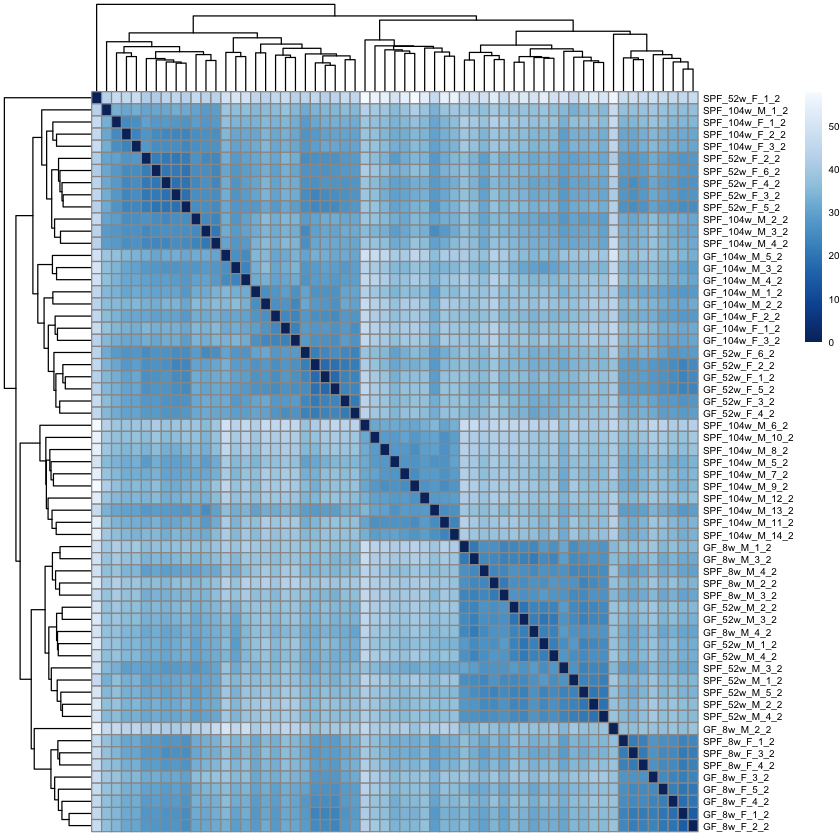

In [37]:
sampleDists = dist(t(assay(vsd)))
sampleDistMatrix = as.matrix( sampleDists )
colnames(sampleDistMatrix) = NULL
colors = colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors,
         fontsize = 6)

PCA plot 

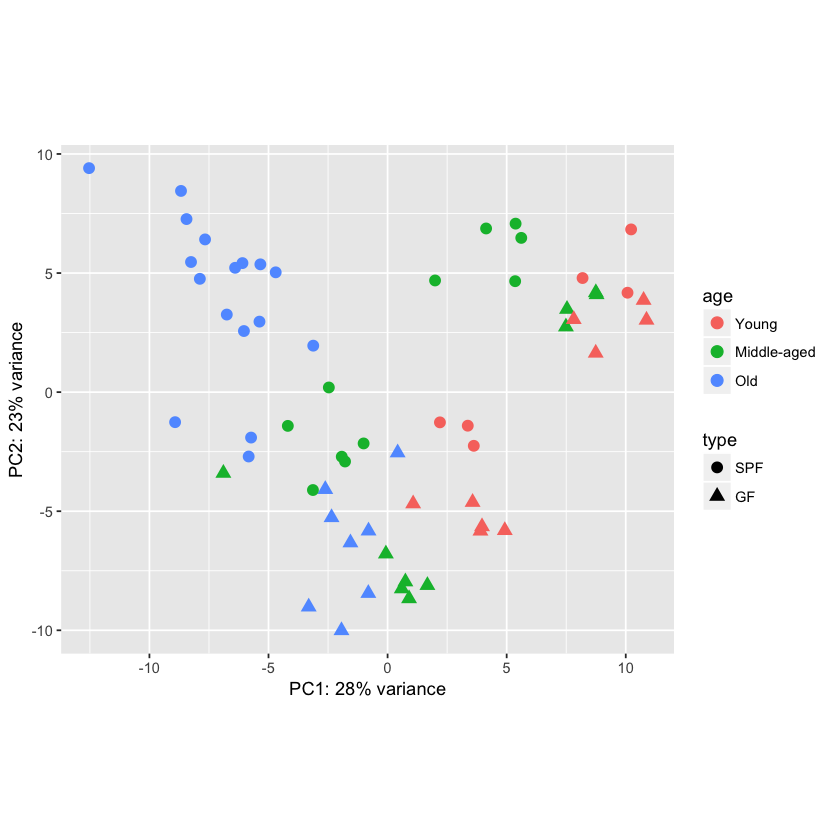

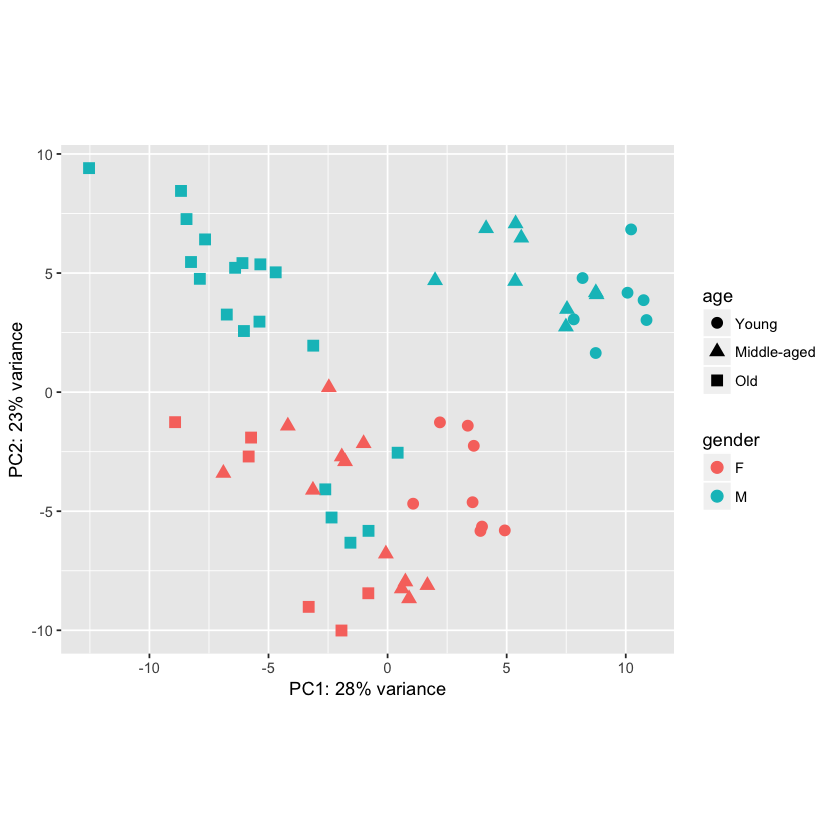

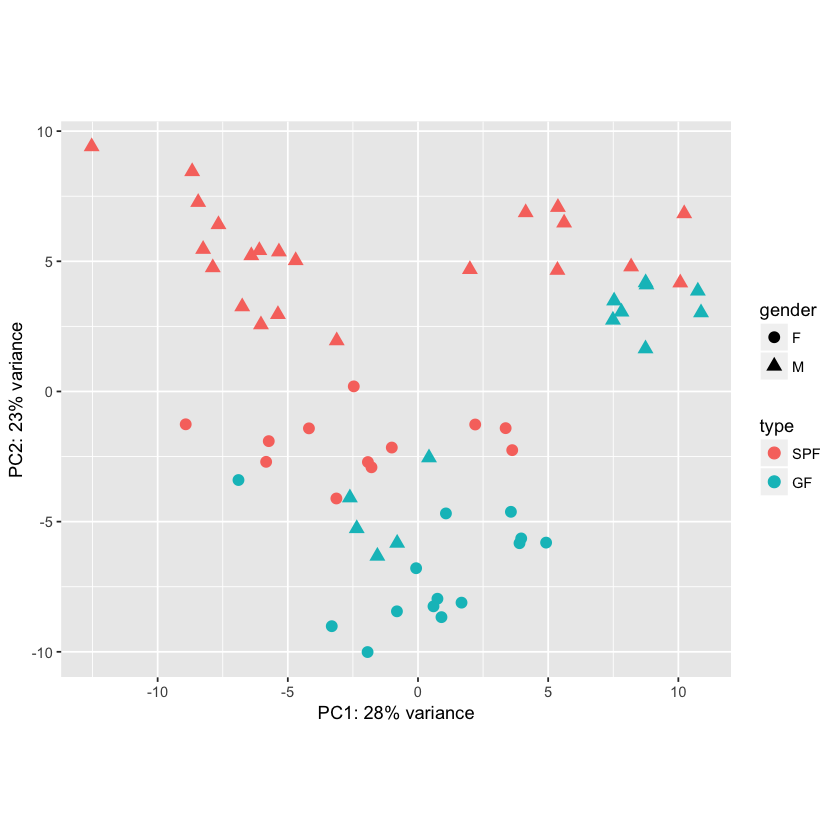

In [38]:
pcaData = plotPCA(vsd, intgroup = c( "type", "gender", "age"), returnData = TRUE)
percentVar = round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(x = PC1, y = PC2, color = age, shape = type)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()
ggplot(pcaData, aes(x = PC1, y = PC2, color = gender, shape = age)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()
ggplot(pcaData, aes(x = PC1, y = PC2, color = type, shape = gender)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()

Batch effect

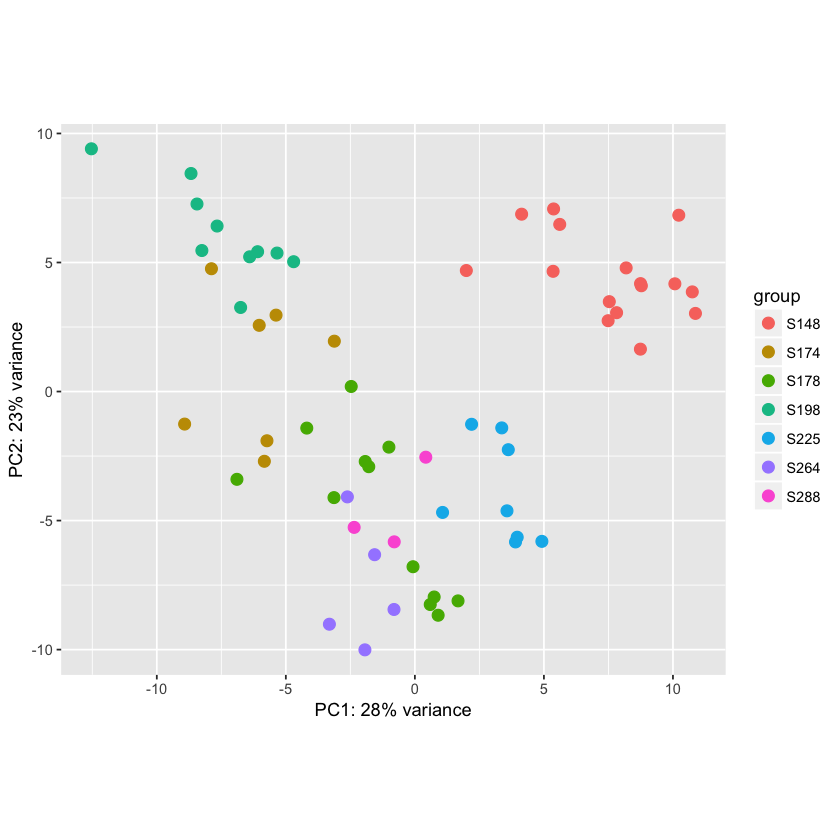

In [39]:
plotPCA(vsd, intgroup = "project")

# Differential expression analysis

In [40]:
dge = DESeq(dds)
save(dge, file = "../results/dge/dge.RData")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
8 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
-- replacing outliers and refitting for 161 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest


Extract and save the normalized counts

In [41]:
norm_counts = counts(dge, normalized = TRUE)
save(norm_counts, file="../results/dge/norm_counts.RData")
write.table(norm_counts, "../results/dge/norm_counts", sep = "\t", quote = FALSE)

Extract and save the Z-scores

In [42]:
mean_counts = apply(norm_counts, 1, mean)
sd_counts = apply(norm_counts, 1, sd)
z_scores = (norm_counts - mean_counts)/sd_counts
save(z_scores, file="../results/dge/z_scores.RData")
write.table(z_scores, "../results/dge/z_scores", sep = "\t", quote = FALSE)

Extract some statistics about the Z-scores
1. Full dimension of Z-scores matrix
2. Z-score higher than 3.5 or smaller than -3.5
3. Percentage of Z-score higher than 3.5 or smaller than -3.5

In [64]:
dim(z_scores)
# z_score higher than 3.5 or smaller than -3.5
s = data.frame("z_scores > 3.5" = apply(z_scores > 3.5, 2, sum, na.rm = T), "z_scores < -3.5" = apply(z_scores < -3.5, 2, sum, na.rm = T))
t(s)
s_perc = 100 * s/dim(norm_counts)[1]
t(s_perc)
data.frame(number = apply(s,2,sum),
           minimum_percentage = apply(s_perc,2,min),
           maximum_percentage = apply(s_perc,2,max),
           row.names = c("z_scores > 3.5", "z_scores < -3.5"))

[1] 19694    61

,GF_104w_F_1_2,GF_104w_F_2_2,GF_104w_F_3_2,GF_104w_M_1_2,GF_104w_M_2_2,GF_104w_M_3_2,GF_104w_M_4_2,GF_104w_M_5_2,GF_52w_F_1_2,GF_52w_F_2_2,⋯,SPF_52w_M_2_2,SPF_52w_M_3_2,SPF_52w_M_4_2,SPF_52w_M_5_2,SPF_8w_F_1_2,SPF_8w_F_3_2,SPF_8w_F_4_2,SPF_8w_M_2_2,SPF_8w_M_3_2,SPF_8w_M_4_2
z_scores...3.5,173,144,130,180,251,203,184,257,84,71,⋯,253,138,260,231,127,108,129,338,305,138
z_scores....3.5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,GF_104w_F_1_2,GF_104w_F_2_2,GF_104w_F_3_2,GF_104w_M_1_2,GF_104w_M_2_2,GF_104w_M_3_2,GF_104w_M_4_2,GF_104w_M_5_2,GF_52w_F_1_2,GF_52w_F_2_2,⋯,SPF_52w_M_2_2,SPF_52w_M_3_2,SPF_52w_M_4_2,SPF_52w_M_5_2,SPF_8w_F_1_2,SPF_8w_F_3_2,SPF_8w_F_4_2,SPF_8w_M_2_2,SPF_8w_M_3_2,SPF_8w_M_4_2
z_scores...3.5,0.8784401,0.7311872,0.6600995,0.913984,1.2745,1.030771,0.9342947,1.304966,0.4265258,0.3605159,⋯,1.284655,0.700721,1.320199,1.172946,0.6448665,0.5483904,0.6550218,1.716259,1.548695,0.700721
z_scores....3.5,0.0000000,0.0000000,0.0000000,0.000000,0.0000,0.000000,0.0000000,0.000000,0.0000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.000000


,number,minimum_percentage,maximum_percentage
z_scores > 3.5,12452,0.3300498,4.1586270
z_scores < -3.5,86,0.0000000,0.3046613


Orders of the factors

In [45]:
resultsNames(dge)

[1] "Intercept"                "gender_M_vs_F"           
 [3] "type_GF_vs_SPF"           "age_Middle.aged_vs_Young"
 [5] "age_Old_vs_Young"         "genderM.ageMiddle.aged"  
 [7] "genderM.ageOld"           "genderM.typeGF"          
 [9] "typeGF.ageMiddle.aged"    "typeGF.ageOld"

Table with the factors

Info | M vs F | GF vs SPF | Middle-aged vs Young | Old vs Young | M & Middle-aged | M & Old | M & GF | GF & Middle-aged | GF & Old
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
M vs F (SPF, Young) | 1 | | | | | | | |
M vs F (GF, Young) | 1 | | | | | | 1 | |
M vs F (SPF, Middle-aged) | 1 | | | | 1 |  | | |
M vs F (GF, Middle-aged) | 1 | | | | 1 | | 1 | |
M vs F (SPF, Old) | 1 | | | | | 1 | | |
M vs F (GF, Old) | 1 | | | | | 1 | 1 | |
M vs F (SPF) | 1 | | | | 1/3 | 1/3 | | |
M vs F (GF) | 1 | | | | 1/3 | 1/3 | | |
M vs F (Young) | 1 | | | | | | 1/2 | |
M vs F (Middle-aged) | 1 | | | | 1 | | 1/2 | |
M vs F (Old) | 1 | | | || 1 | 1/2 | |
M vs F | 1 | | | | 1/3 | 1/3 | 1/2 | |
GF vs SPF (F, Young) | | 1 | | | | | | |
GF vs SPF (M, Young) | | 1 | | | | | 1 | |
GF vs SPF (F, Middle-aged) | | 1 | | | | | | 1 |
GF vs SPF (M, Middle-aged) | | 1 | | | | | 1 | 1 |
GF vs SPF (F, Old) | | 1 | | | | | | | 1
GF vs SPF (M, Old) | | 1 | | | | | 1 | | 1
GF vs SPF (F) | | 1 | | | | | | 1/3 | 1/3
GF vs SPF (M) | | 1 | | | | | 1 | 1/3 | 1/3
GF vs SPF (Young) | | 1 | | | | | 1/2 | |
GF vs SPF (Middle-aged) | | 1 | | | | | 1/2 | 1 |
GF vs SPF (Old) | | 1 | | |  | | 1/2 | | 1
GF vs SPF | | 1 | | | |  | 1/2 | 1/3 | 1/3
Middle-aged vs Young (F, SPF) | | | 1 | | | | | |
Middle-aged vs Young (F, GF) | | | 1 | | | | | 1 |
Middle-aged vs Young (M, SPF) | | | 1 | | 1 | | | |
Middle-aged vs Young (M, GF) | | | 1 | | 1 | | | 1 |
Middle-aged vs Young (F) | | | 1 | | | | | 1/2 |
Middle-aged vs Young (M) | | | 1 | | 1 | | | 1/2 |
Middle-aged vs Young (SPF) | | | 1 |  | 1/2 | | | |
Middle-aged vs Young (GF) | | | 1 |  | 1/2 | | | 1 |
Middle-aged vs Young | | | 1 | | 1/2 | | | 1/2 |
Old vs Young (F, SPF) | | | | 1 | | | | |
Old vs Young (F, GF) | | | | 1 | | | | | 1
Old vs Young (M, SPF) | | | | 1 | | 1 | | |
Old vs Young (M, GF) | | | | 1| | 1 | | | 1
Old vs Young (F) | | | | 1| | | | | 1/2
Old vs Young (M) | | | | 1| | 1 | | | 1/2
Old vs Young (SPF) | | | | 1| | 1/2 | | |
Old vs Young (GF) | | | | 1| | 1/2 | | | 1
Old vs Young | | | | 1 | | 1/2 | | | 1/2
Old vs Middle-aged (F, SPF) | | | -1 | 1 | | | | |
Old vs Middle-aged (F, GF) | | | -1 | 1 | | | | -1 | 1
Old vs Middle-aged (M, SPF) | | | -1 | 1 | -1 | 1 | | |
Old vs Middle-aged (M, GF) | | | -1 | 1 | -1 | 1 | | -1 | 1
Old vs Middle-aged (F) | | | -1 | 1 | | | | -1/2 | 1/2
Old vs Middle-aged (M) | | | -1 | 1 | -1 | 1 | | -1/2 | 1/2
Old vs Middle-aged (SPF) | | | -1 | 1 | -1/2 | 1/2 | | |
Old vs Middle-aged (GF) | | | -1 | 1 | -1/2 | 1/2 | | |
Old vs Middle-aged | | | -1 | 1 | -1/2 | 1/2 | | -1/2 | 1/2